# 1. Setup

## 1.1 Install Dependencies

In [3]:
# !pip3 install opencv-python matplotlib tensorflow-macos tensorflow-metal keras tensorflow

  Using cached opencv_python-4.7.0.68-cp37-abi3-macosx_10_13_x86_64.whl (51.7 MB)
ERROR: Could not find a version that satisfies the requirement tensorflow-macos (from versions: none)
ERROR: No matching distribution found for tensorflow-macos


## 1.2 Import Dependencies

In [2]:
#import standard dependencies
import cv2
import os
import random
# good to work for arrays, good for tensorflow
import numpy as np
# can help visualize an image
from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf

# import tensorflow dependencies
# usually people use the sequential tensorflow api, but functional tensorflow api is much more flexible in terms of hardcore processing
# building a siamanese nerual network. comparing two images and seeing if their the same
# passing 2 images at the same time, and finding the similarity between the two images
# importing functional api

# most imported = Model(Input=[input image, verification image], Output=[1,0])
from tensorflow.keras.models import Model
# lots of layer types for NN
# Layer=high level class (creating a custom layer)
# Conv2D (standard layer) Called a convoluntional layer usually for CNN, forming convolutions
# Dense, a fully connected layer
# MaxPooling2D, Pool layers together and shrinks info together, taking max value overa certain region
# Input, determines what you input into NN, input(shape=)
# Flatten, takes all info form a layer and flattens it into more simpler
# Import tensorflow dependencies - Functional API
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

2023-02-09 09:02:39.493414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.3 Set GPU Growth

In [57]:
# Avoid out of memory errors, by setting GPU memory consumption Growth

# accessing all GPUs on machine
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    # setting memory growth 
    tf.config.experimental.set_memory_growth(gpu, True)

In [58]:
# create 3 folders for data
# anchor (real time input), positive, and negative

# setup paths
POS_PATH = os.path.join('data', "positive")
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

## 1.4 Create Folder Structures

In [59]:
# making directories

# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [60]:
# Uncompress TAR GZ Labelled Faces in the Wild Dataset

# !tar -xf lfw.tgz

In [61]:
# # Move LFW Images from folder to the following respository data/negative, done by redirecting the path

# gives directory/folder name for every single folder in 'lfw' folder
# for directory in os.listdir('lfw'):
#   # loops through every image in every folder and get path
#   for file in os.listdir(os.path.join('lfw', directory)):
#     # manipulate directory
#     EX_PATH = os.path.join('lfw', directory, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [62]:
# Import uuid library to generate unique image names
import uuid

In [63]:
# os.path.join(ANC_PATH, '{a}.jpg'.format(uuid.uuid1()))

In [64]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px, (y,x)
    frame = frame[200:200+250,600:600+250, :]
    
    # Collect anchors when click a
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path and placing in folder
        imgname = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives when click p
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# good to help forcefully stop cv2 webcam, in case of freezing
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows

1   HIToolbox                           0x00007ff8247c552b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff8246be33e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff82462d7a4 _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 46
4   HIToolbox                           0x00007ff8246be93d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff824624bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff824656fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff824658871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff824658225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff8246580fb _ZL14Messag

KeyboardInterrupt: 

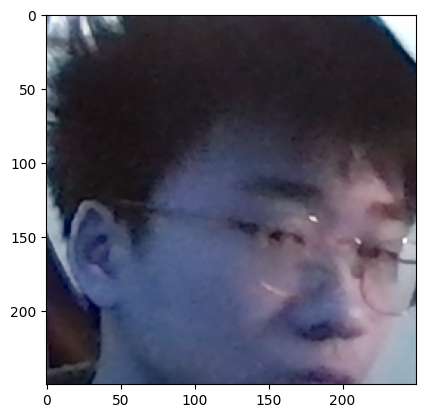

In [ ]:
# print frame for testing
plt.imshow(frame)

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [65]:
# getting images within directory
# Basically get 300 files that have the PATH and the .jpg in the name
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

## 3.2 Preprocessing - Scale and Resize

In [66]:
def preprocess(file_path):
    # Reading image from file path
    byte_img = tf.io.read_file(file_path)
    # loading image
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing steps
    # resize image
    img = tf.image.resize(img, (100,100))
    # scaling image to be between 1 and 0
    img /= 255.0 
    return img

# 3.3 Create Labelled Dataset

(anchor, positive) => [1,1,1,1,1]
(anchor, negative) => [0,0,0,0,0]

In [67]:
# .zip allows to zip everything up and iterate everything at the same time

# creating a dataset using anchor, positive/negative, and an array of 1s or 0s that matches the shape of the anchor
# saying that if we compare the anchor to positive, we want it to be 1, if we compare anchor to negative, we want it to be 0
postives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# joining positives and negatives dataset together
data = postives.concatenate(negatives)

# 3.4 Build Train and Test Partition

1.0

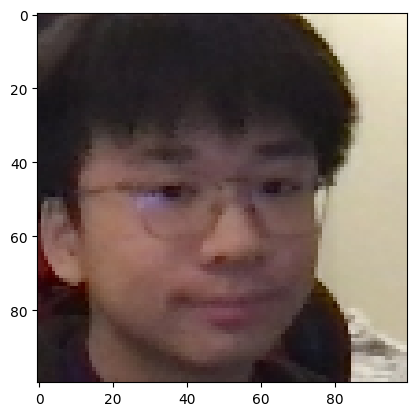

In [70]:
def preprocess_twin(input_img, validation_img, label):
    # input_img -> anchor, validation_img -> positive/negative
    return(preprocess(input_img), preprocess(validation_img), label)

res = preprocess_twin(*exampple)
plt.imshow(res[1])
res[2]

In [ ]:
# Build Dataloader pipline
data = data.map(preprocess_twin) #applies function to the entire data set
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
# but 16 images in one group to train at one time
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

## 4.2 Build Distance Layer

## 4.3 Make Siamese Model

# 5. Training

## 5.1 Setup Loss and Optimizer

## 5.2 Establish Checkpoints

## 5.3 Build Train Step Function

## 5.4 Build Training Loop

## 5.5 Train the model

# 6. Evaluate Model

# 7. Save Model

# 8. Real Time Test